# 1. Extract features of training and test images using a pre-trained ResNet50 model (50 points)
Please print the size of extracted features, e.g., training features: 1400 * d, test features: 400 *d.

In [53]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import scipy.io
import glob
from sklearn.svm import SVC  # Changed from SVR to SVC
from sklearn.neighbors import KNeighborsClassifier  # Changed from KNeighborsRegressor
from sklearn.metrics import accuracy_score  # Changed from regression metrics

# Check for MPS availability
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [55]:
train_image_dir = "/Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/Datasets/Train/Images"
train_label_dir = "/Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/Datasets/Train/Labels"
val_image_dir = "/Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/Datasets/Valid/Images"
val_label_dir = "/Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/Datasets/Valid/Labels"
test_image_dir = "/Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/Datasets/Test_images"

In [57]:
class DogCardiomegalyDataset(Dataset):
    def __init__(self, image_dir, label_dir=None, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_files = sorted(glob.glob(os.path.join(image_dir, "*.png")))
        print(f"Found {len(self.image_files)} images in {image_dir}")

        if label_dir:
            self.label_files = sorted(glob.glob(os.path.join(label_dir, "*.mat")))
            print(f"Found {len(self.label_files)} labels in {label_dir}")

            # Filter to only include matching pairs
            image_basenames = {os.path.splitext(os.path.basename(f))[0] for f in self.image_files}
            label_basenames = {os.path.splitext(os.path.basename(f))[0] for f in self.label_files}
            common_basenames = image_basenames.intersection(label_basenames)

            self.image_files = [os.path.join(image_dir, f"{name}.png") for name in common_basenames]
            self.label_files = [os.path.join(label_dir, f"{name}.mat") for name in common_basenames]
            print(f"After pairing: {len(self.image_files)} matched image-label pairs")
        else:
            self.label_files = None

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        if self.label_files:
            mat_path = self.label_files[idx]
            mat_data = scipy.io.loadmat(mat_path)
            vhs = mat_data["VHS"][0][0]  # Extract VHS value
            # Convert VHS to class label
            if vhs < 9.7:
                label = 0  # Small
            elif 9.7 <= vhs <= 10.7:
                label = 1  # Normal
            else:
                label = 2  # Large
            return img, torch.tensor(label, dtype=torch.long)
        return img, None  # For test set

In [59]:
# Custom collate function to handle None targets
def custom_collate(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    images = torch.stack(images, dim=0)
    if all(t is None for t in targets):  # Test set case
        return images, None
    targets = torch.stack(targets, dim=0)
    return images, targets

# Transform for feature extraction
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = DogCardiomegalyDataset(train_image_dir, train_label_dir, transform=transform)
val_dataset = DogCardiomegalyDataset(val_image_dir, val_label_dir, transform=transform)
test_dataset = DogCardiomegalyDataset(test_image_dir, transform=transform)

# DataLoaders with custom collate
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

Found 1395 images in /Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/Datasets/Train/Images
Found 1400 labels in /Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/Datasets/Train/Labels
After pairing: 1395 matched image-label pairs
Found 200 images in /Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/Datasets/Valid/Images
Found 200 labels in /Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/Datasets/Valid/Labels
After pairing: 200 matched image-label pairs
Found 400 images in /Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/Datasets/Test_images
Train samples: 1395, Val samples: 200, Test samples: 400


In [61]:
from torchvision.models import ResNet50_Weights

# Load pre-trained ResNet50 with weights
resnet50 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
resnet50 = nn.Sequential(*list(resnet50.children())[:-1])  # Remove the final FC layer
resnet50 = resnet50.to(device)
resnet50.eval()

# Function to extract features
def extract_features(model, loader):
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            feats = model(images)
            feats = feats.view(feats.size(0), -1)  # Flatten to [batch_size, 2048]
            features.append(feats.cpu().numpy())
            if targets is not None:  # Only append if targets exist (train/val)
                labels.append(targets.numpy())
    
    features = np.concatenate(features, axis=0)
    if labels:  # Check if labels list is non-empty
        labels = np.concatenate(labels, axis=0)
    else:
        labels = None
    return features, labels

# Extract features
train_features, train_labels = extract_features(resnet50, train_loader)
val_features, val_labels = extract_features(resnet50, val_loader)
test_features, test_labels = extract_features(resnet50, test_loader)  # test_labels will be None

# Print feature sizes
print(f"Training features: {train_features.shape[0]} * {train_features.shape[1]}")
print(f"Validation features: {val_features.shape[0]} * {val_features.shape[1]}")
print(f"Test features: {test_features.shape[0]} * {test_features.shape[1]}")

Training features: 1395 * 2048
Validation features: 200 * 2048
Test features: 400 * 2048


# 2. Call SVM and kNN from scikit-learn and train the extracted deep features, respectively (30 points)

In [63]:
# Train SVM (SVC)
svm = SVC(kernel="linear")
svm.fit(train_features, train_labels)
svm_val_pred = svm.predict(val_features)
svm_test_pred = svm.predict(test_features)
svm_val_accuracy = accuracy_score(val_labels, svm_val_pred)
print(f"SVM Validation Accuracy: {svm_val_accuracy:.4f}")

# Train kNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_features, train_labels)
knn_val_pred = knn.predict(val_features)
knn_test_pred = knn.predict(test_features)
knn_val_accuracy = accuracy_score(val_labels, knn_val_pred)
print(f"kNN Validation Accuracy: {knn_val_accuracy:.4f}")

SVM Validation Accuracy: 0.6100
kNN Validation Accuracy: 0.5850


In [67]:
# Save predictions without headers
def save_predictions(predictions, output_file, image_dir):
    image_files = sorted(glob.glob(os.path.join(image_dir, "*.png")))
    class_map = {0: "Small", 1: "Normal", 2: "Large"}
    with open(output_file, "w") as f:
        for img_path, pred in zip(image_files, predictions):
            img_name = os.path.basename(img_path)
            class_name = class_map[pred]
            f.write(f"{img_name},{class_name}\n")

save_predictions(svm_test_pred, "svm_test_predictions.csv", test_image_dir)
save_predictions(knn_test_pred, "knn_test_predictions.csv", test_image_dir)

print("Test predictions saved. Run Dog_X_ray_classfication_accuracy software on 'svm_test_predictions.csv' and 'knn_test_predictions.csv'.")

Test predictions saved. Run Dog_X_ray_classfication_accuracy software on 'svm_test_predictions.csv' and 'knn_test_predictions.csv'.


# 3. Report the accuracy using Dog_X_ray_classfication_accuracy software, please attach the results image here (20 points)

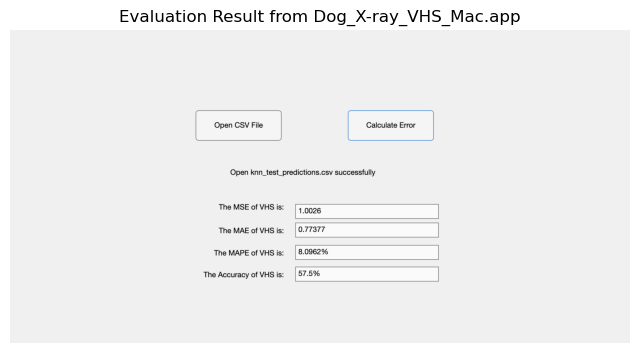

In [80]:
import matplotlib.image as mpimg

# Path to the screenshot of the evaluation result
image_path = "/Users/prashantsoni/Desktop/Dog_Cardiomegaly_Detection/Screenshot 2025-03-26 at 11.21.26 AM.png"

# Display the image
img = mpimg.imread(image_path)
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.title("Evaluation Result from Dog_X-ray_VHS_Mac.app")
plt.show()

Since, SVM (SVC) doesn’t predict continuous values. If we wanted to predict the exact VHS values (e.g., 11.3614), we’d use SVR (Support Vector Regression) instead. However, the instruction explicitly states "SVM and kNN" for training the extracted features, So below is the bar plot for the "*svm_test_predictions.csv*"



/var/folders/3v/8qrhcvp56kz851ytyycj38r00000gn/T/ipykernel_63943/3978692300.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=size_counts.index, y=size_counts.values, palette="viridis")


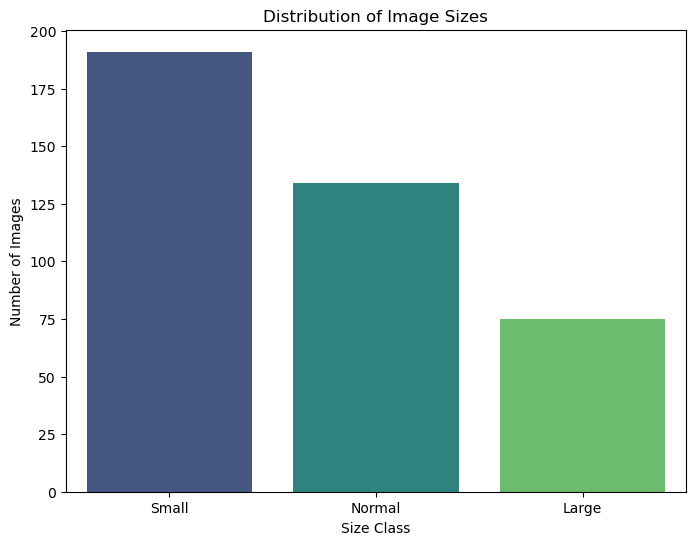

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file without headers and assign column names
df = pd.read_csv("svm_test_predictions.csv", header=None, names=["FileName", "Size"])

# Count occurrences of each size class
size_counts = df["Size"].value_counts()

# Create the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=size_counts.index, y=size_counts.values, palette="viridis")
plt.title("Distribution of Image Sizes")
plt.xlabel("Size Class")
plt.ylabel("Number of Images")
plt.show()